In [1]:
import os
import pandas as pd
import numpy as np
import io
import json
import pickle
import requests
import joblib
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from lightgbm import LGBMClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings("ignore")

### OPEN THE DATA

In [2]:
# open data and set 'Date' column to datetime format
train = pd.read_csv('data/train.csv',parse_dates=['Date'])
train.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01 01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01 02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01 09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01 10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01 10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856610 entries, 0 to 856609
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype              
---  ------                                    --------------   -----              
 0   observation_id                            856610 non-null  object             
 1   Type                                      856610 non-null  object             
 2   Date                                      856610 non-null  datetime64[ns, UTC]
 3   Part of a policing operation              646620 non-null  object             
 4   Latitude                                  700308 non-null  float64            
 5   Longitude                                 700308 non-null  float64            
 6   Gender                                    856610 non-null  object             
 7   Age range                                 856610 non-null  object             
 8   Self-defined ethnicity                    84

### FEATURE ENGINEERING

#### Part of a policing operation

In [4]:
# check whether the search opperation was part of a policing operation or not 
train['Part of a policing operation'].value_counts(dropna=False)

False    628148
NaN      209990
True      18472
Name: Part of a policing operation, dtype: int64

There's a lot of missing values here. There are 2 options here: either I replace the NaNs with "Unknown" or similar to what was done for the "Removal of clothing" feature I assume the officers forgot to fill this field and replace NaNs with False

In [5]:
#train['Part of a policing operation'] = train['Part of a policing operation'].fillna('Unknown')
#train['Part of a policing operation'] = train['Part of a policing operation'].fillna(False)
#train['Part of a policing operation'].value_counts(dropna=False)

#### Date

In [6]:
# get the hour and day of the week, maybe they will be useful 
train['hour'] = train['Date'].dt.hour
train['month'] = train['Date'].dt.month
train['day_of_week'] = train['Date'].dt.day_name()

#### Gender

In [7]:
# check the gender of the target of the search opperation
train['Gender'].value_counts(dropna=False,normalize=True)*100

Male      90.422246
Female     9.472105
Other      0.105649
Name: Gender, dtype: float64

There's no missing values, but the "Other" category has very few instances so I might try to drop it and see if it improves the model

In [8]:
#train = train[~train['Gender'].isin(['Other'])]
#train['Gender'].value_counts(dropna=False)

#### Age

In [9]:
# check the age of the target of the search opperation
train['Age range'].value_counts(dropna=False)

18-24       307185
25-34       215998
over 34     184905
10-17       148083
under 10       439
Name: Age range, dtype: int64

There's no missing values, but the "under 10" category has very few instances so I might try to drop it and see if it improves the model.

In [10]:
#train = train[~train['Age range'].isin(['under 10'])]
#train['Age range'].value_counts(dropna=False)

#### Officer-defined ethinicity

In [11]:
train['Officer-defined ethnicity'].value_counts(dropna=False)

White    507627
Black    197137
Asian    119785
Other     29035
Mixed      3026
Name: Officer-defined ethnicity, dtype: int64

Once again there's very few cases of searches in "Mixed" ethnicities so I might want to drop those.

In [12]:
#train = train[~train['Officer-defined ethnicity'].isin(['Mixed','Other'])]
#train['Officer-defined ethnicity'].value_counts(dropna=False)

#### Legislation

In [13]:
#legislation_counts = train['Legislation'].value_counts(dropna=False)
#legislation_counts

In [14]:
# fill missing values with Unknonw
#train['Legislation'] = train['Legislation'].fillna('Unknown')

Maybe I'll want to remove the cases where the legislation were very rare.

In [15]:
# Get list of legislations that appear less than 100 of times in dataset. Mayve I can try to remove these cases
#rare_legistlations = legislation_counts[legislation_counts < 100].index.to_list()
#rare_legistlations

In [16]:
#train = train[~train['Legislation'].isin(rare_legistlations)]
#train['Legislation'].value_counts(dropna=False)

#### Object of search

In [17]:
train['Object of search'].value_counts(dropna=False)

Controlled drugs                                  558100
Offensive weapons                                 112652
Stolen goods                                       75698
Article for use in theft                           38706
Evidence of offences under the Act                 23080
Articles for use in criminal damage                16696
Anything to threaten or harm anyone                15535
Firearms                                            5420
Fireworks                                           5072
Psychoactive substances                             4805
Game or poaching equipment                           321
Detailed object of search unavailable                309
Goods on which duty has not been paid etc.            97
Crossbows                                             54
Evidence of wildlife offences                         46
Evidence of hunting any wild mammal with a dog        12
Seals or hunting equipment                             7
Name: Object of search, dtype: 

Again some rare cases there. I might want to remove these 4/5 instances.

In [18]:
#object_search_counts = train['Object of search'].value_counts(dropna=False)
#rare_objects = object_search_counts[object_search_counts < 5000].index.to_list()
#rare_objects

In [19]:
#train = train[~train['Object of search'].isin(rare_objects)]
#train['Object of search'].value_counts(dropna=False)

#### Police station

In [20]:
# There are some police stations that have a 0% success rate. Perhaps those should also be excluded from the analsysis
no_data_stations = ['humberside','lancashire','metropolitan']
almost_no_data_stations = ['humberside','lancashire','metropolitan','leicestershire',
                           'west-midlands','south-yorkshire','dyfed-powys','lincolnshire']

train = train[~train['station'].isin(almost_no_data_stations)]
train['station'].value_counts(dropna=False)

merseyside            38563
thames-valley         31437
west-yorkshire        25321
hampshire             20230
btp                   18557
kent                  17875
hertfordshire         13971
avon-and-somerset     13189
essex                 12889
sussex                11378
devon-and-cornwall    10906
surrey                10774
west-mercia            9262
staffordshire          9039
norfolk                8766
cheshire               8271
northumbria            8034
cleveland              7907
nottinghamshire        7523
north-wales            7044
suffolk                6482
bedfordshire           5904
city-of-london         4539
northamptonshire       4427
warwickshire           3923
durham                 3585
north-yorkshire        3563
gloucestershire        3542
derbyshire             3419
cambridgeshire         3367
cumbria                3022
wiltshire              2867
dorset                 2857
Name: station, dtype: int64

#### Create Target Feature

In [21]:
train['Target'] = (train['Outcome linked to object of search'] == True) & (train['Outcome'] != 'A no further action disposal')

In [22]:
train['Target'].value_counts(dropna=False,normalize=True)*100

False    80.219196
True     19.780804
Name: Target, dtype: float64

### MODEL

In [23]:
# Other models tried
#RandomForestClassifier(max_depth=9,random_state=42)
#RandomForestClassifier(max_depth=4,class_weight={0:1,1:2},random_state=42))
#LGBMClassifier(max_depth=2,random_state=42)
#LogisticRegression(random_state=42,class_weight={0:1,1:2},max_iter=3,solver='newton-cholesky'))
#LogisticRegression(random_state=42,solver='newton-cholesky')
#XGBClassifier(max_depth=10,random_state=42)

List all columns that should be dropped (either because they're not useful) or because the officer won't have access to them before doing the search

In [24]:
cols_to_drop = ['observation_id','Date','Longitude','Latitude','Self-defined ethnicity',
                'Outcome','Outcome linked to object of search','Removal of more than just outer clothing']

train = train.drop(columns=cols_to_drop)

In [25]:
train.head(10)

,Type,Part of a policing operation,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,hour,month,day_of_week,Target
0,Person search,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,hampshire,1,12,Tuesday,False
1,Person search,NaN,Male,over 34,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,2,12,Tuesday,False
2,Person search,NaN,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,9,12,Tuesday,False
3,Person search,NaN,Male,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,hampshire,10,12,Tuesday,False
4,Person search,NaN,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,10,12,Tuesday,False
5,Person search,NaN,Male,18-24,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,10,12,Tuesday,False
6,Person search,NaN,Male,over 34,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,10,12,Tuesday,False
7,Person search,NaN,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,11,12,Tuesday,False
8,Person search,NaN,Male,18-24,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,11,12,Tuesday,False
9,Person search,NaN,Male,10-17,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,11,12,Tuesday,False


In [26]:
### New round of requests
df_new = pd.read_csv('first_round_requests/firstround_requests_clean.csv',parse_dates=['Date'])

In [27]:
df_new['hour'] = df_new['Date'].dt.hour
df_new['month'] = df_new['Date'].dt.month
df_new['day_of_week'] = df_new['Date'].dt.day_name()

In [28]:
df_new['Target'] = df_new['true_class'].map({1:bool(True),0:bool(False)})

In [29]:
df_new.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,proba,pred,true_class,hour,month,day_of_week,Target
0,Person and Vehicle search,2022-01-01 03:08:37+00:00,NaN,52.312706,-0.225271,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire,0.715158,True,1.0,3,1,Saturday,True
1,Person search,2022-01-01 04:29:00+00:00,True,50.625847,-3.546839,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.446089,False,0.0,4,1,Saturday,False
2,Person search,2022-01-01 05:50:23+00:00,NaN,51.518091,-0.078308,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.127540,False,0.0,5,1,Saturday,False
3,Person search,2022-01-01 07:34:03+00:00,NaN,51.506255,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.173887,False,0.0,7,1,Saturday,False
4,Person search,2022-01-01 16:43:00+00:00,False,50.725010,-3.524855,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.462372,False,1.0,16,1,Saturday,True


In [30]:
df_new.drop(columns=['Date','proba','pred'],inplace=True)

In [31]:
df_new.drop(columns=['Longitude','Latitude','true_class'],inplace=True)

In [32]:
df_new.columns

Index(['Type', 'Part of a policing operation', 'Gender', 'Age range',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station', 'hour', 'month', 'day_of_week', 'Target'],
      dtype='object')

In [33]:
train.columns

Index(['Type', 'Part of a policing operation', 'Gender', 'Age range',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station', 'hour', 'month', 'day_of_week', 'Target'],
      dtype='object')

In [34]:
train_new = train.append(df_new, ignore_index=True)

In [35]:
train_new.head()

,Type,Part of a policing operation,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,hour,month,day_of_week,Target
0,Person search,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,hampshire,1,12,Tuesday,False
1,Person search,NaN,Male,over 34,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,2,12,Tuesday,False
2,Person search,NaN,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire,9,12,Tuesday,False
3,Person search,NaN,Male,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,hampshire,10,12,Tuesday,False
4,Person search,NaN,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,10,12,Tuesday,False


In [36]:
train_new['Target'].value_counts(dropna=False,normalize=True)*100

False    80.195016
True     19.804695
NaN       0.000289
Name: Target, dtype: float64

In [37]:
train_new = train_new[train_new['Target'].notna()]

In [38]:
train_new['Target'].value_counts(dropna=False,normalize=True)*100

False    80.195248
True     19.804752
Name: Target, dtype: float64

In [39]:
train_new['Target'] = train_new['Target'].astype(bool)

In [40]:
train_new['Target'].value_counts(dropna=False,normalize=True)*100

False    80.195248
True     19.804752
Name: Target, dtype: float64

In [41]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346432 entries, 0 to 346432
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Type                          346432 non-null  object
 1   Part of a policing operation  188143 non-null  object
 2   Gender                        346432 non-null  object
 3   Age range                     346432 non-null  object
 4   Officer-defined ethnicity     346432 non-null  object
 5   Legislation                   306802 non-null  object
 6   Object of search              346432 non-null  object
 7   station                       346432 non-null  object
 8   hour                          346432 non-null  int64 
 9   month                         346432 non-null  int64 
 10  day_of_week                   346432 non-null  object
 11  Target                        346432 non-null  bool  
dtypes: bool(1), int64(2), object(9)
memory usage: 32.0+ MB


#### Baseline Model

In [42]:
# Load the data
data = train_new

# Split the data into features and target
X = data.drop(columns=['Target'])
y = data['Target']

# Oversample minority class
oversamp = RandomOverSampler(sampling_strategy='minority',random_state=42) # Using RandomOverSampler
X, y = oversamp.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.3, random_state=42)
#X_train,y_train = oversamp.fit_resample(X_train,y_train)

# Define the categorical features and the categorical transformer
categorical_features = list(X.columns[X.dtypes=='object'])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)])

# Set up the pipeline with the preprocessor and the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier',XGBClassifier(max_depth=10,random_state=42))])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
probs = model.predict_proba(X_test)

# set the threshold probability to more than 0.1 (10%)
preds = (probs[:, 1] > 0.35).astype(int) 

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.599493683035982
F1 Score: 0.6997436474027434
Precision: 0.5596569858204499
Recall: 0.933374926512052


In [43]:
pd.Series(preds).value_counts()

1    139003
0     27691
dtype: int64

AUC-ROC: 0.599493683035982


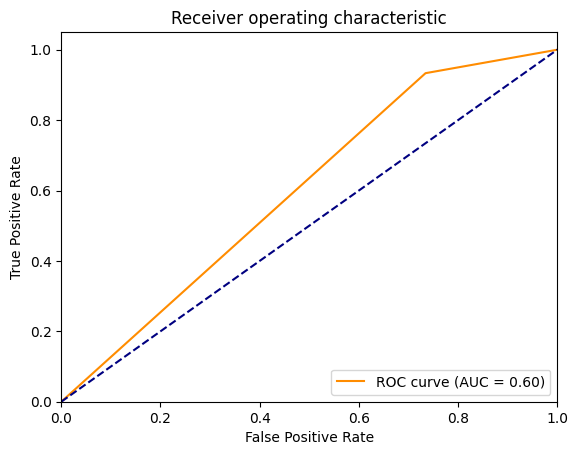

In [44]:
# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, preds)
print('AUC-ROC:', auc_roc)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, preds)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[0.13280622 0.36719378]
 [0.03331254 0.46668746]]


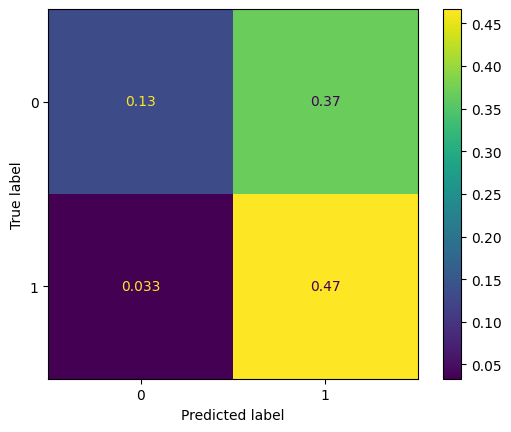

In [45]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds,normalize='all')

# Plot confusion matrix
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

Feature ranking:
1. feature Object of search_Controlled drugs (0.144665)
2. feature station_merseyside (0.060642)
3. feature station_hampshire (0.038150)
4. feature Legislation_Criminal Justice and Public Order Act 1994 (section 60) (0.037885)
5. feature station_norfolk (0.032965)
6. feature station_durham (0.027982)
7. feature station_kent (0.024016)
8. feature Object of search_Stolen goods (0.023706)
9. feature station_thames-valley (0.023378)
10. feature Gender_Male (0.019617)
11. feature station_west-yorkshire (0.019139)


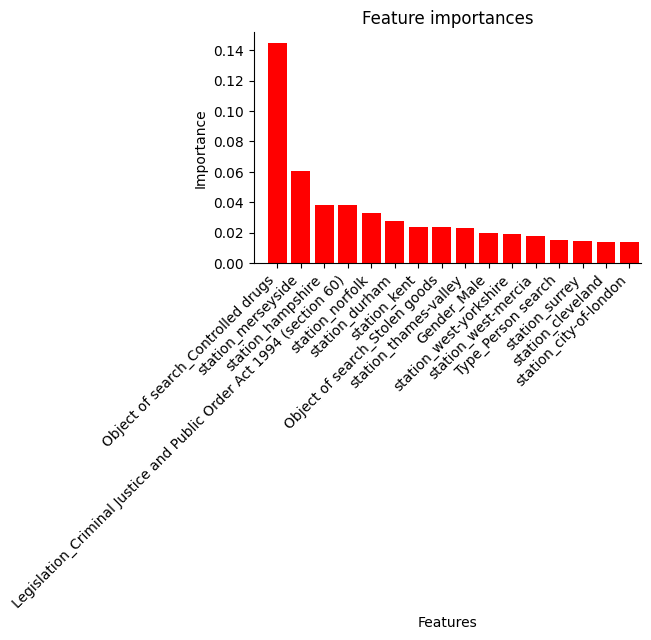

In [46]:
# Get the feature importances (FOR XGBOOST CLASSIFIER)
onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
                    .get_feature_names_out(input_features=categorical_features)
importances = pd.Series(data=model.named_steps['classifier'].feature_importances_, index = np.array(list(onehot_columns)))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

# Plot the feature importances
plt.figure(figsize=(5,3))
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]+4.5])
plt.xlabel('Features');
plt.ylabel('Importance');
sns.despine()
plt.tight_layout()
plt.show()

In [47]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.5):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision

In [48]:
verify_success_rate_above(y_test, preds, min_success_rate=0.5)

(True, 0.5596569858204499)

In [49]:
def verify_no_discrimination_stations(X_test, y_true, y_pred, sensitive_column, max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination between "sensitive_column" categories
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_departments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_departments

In [50]:
# Evaluate the model success between (officer-defined) ethnicities
print("Officer-defined ethnicity:\n")

is_satisfied, problematic_departments, good_departments = verify_no_discrimination_stations(
    X_test, y_test, preds, sensitive_column='Officer-defined ethnicity',max_diff=0.20)


if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_departments)))
    print ('\n')
    print ("Problematic departments:",[i[0] for i in problematic_departments])
    print ('\n')
    print ("Good departments:",[i[0] for i in good_departments])
    print ('\n')
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))

print("Departments analysed: {}".format(len(problematic_departments) + len(good_departments)))

Officer-defined ethnicity:

Requirement failed 😢
Num problematic departments: 8
Num good departments: 25


Problematic departments: ['durham', 'norfolk', 'northumbria', 'staffordshire', 'northamptonshire', 'dorset', 'north-wales', 'north-yorkshire']


Good departments: ['west-yorkshire', 'warwickshire', 'btp', 'surrey', 'hertfordshire', 'kent', 'bedfordshire', 'hampshire', 'west-mercia', 'thames-valley', 'cheshire', 'essex', 'cumbria', 'cleveland', 'avon-and-somerset', 'merseyside', 'nottinghamshire', 'sussex', 'cambridgeshire', 'derbyshire', 'wiltshire', 'city-of-london', 'suffolk', 'devon-and-cornwall', 'gloucestershire']


avg diff: 0.3398837480058525
Departments analysed: 33


In [51]:
def verify_no_discrimination_object_of_search(X_test, y_true, y_pred, sensitive_column, max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination between "sensitive_column" categories
    
    """
    
    departments = X_test['Object of search'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['Object of search'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments

In [52]:
# Evaluate the model success between "object of search" categories
print("Object of search:\n")

is_satisfied, problematic_searches, good_searches = verify_no_discrimination_object_of_search(
    X_test, y_test, preds, sensitive_column='Officer-defined ethnicity',max_diff=0.30)


if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic search categories: {}".format(len(problematic_searches)))
    print("Num good search cateogories: {}".format(len(good_searches)))
    print ('\n')
    print ("Problematic search categories:",[i[0] for i in problematic_searches])
    print ('\n')
    print ("Good search categories:",[i[0] for i in good_searches])
    print ('\n')
    print("avg diff:", np.mean([p[1] for p in problematic_searches]))

print("Objects of search categories analysed: {}".format(len(problematic_searches) + len(good_searches)))

Object of search:

Requirement failed 😢
Num problematic search categories: 9
Num good search cateogories: 8


Problematic search categories: ['Firearms', 'Evidence of offences under the Act', 'Game or poaching equipment', 'Anything to threaten or harm anyone', 'Articles for use in criminal damage', 'Fireworks', 'Detailed object of search unavailable', 'Goods on which duty has not been paid etc.', 'Crossbows']


Good search categories: ['Controlled drugs', 'Offensive weapons', 'Stolen goods', 'Psychoactive substances', 'Article for use in theft', 'Evidence of wildlife offences', 'Evidence of hunting any wild mammal with a dog', 'Seals or hunting equipment']


avg diff: 0.5678872966303631
Objects of search categories analysed: 17


#### SERIALIZE MODEL

In [53]:
# with open('columns_capstone_v2.json', 'w') as fh:
#     json.dump(X_train.columns.tolist(), fh)
    
# with open('dtypes_capstone_v2.pickle', 'wb') as fh:
#     pickle.dump(X_train.dtypes, fh)

# joblib.dump(model,'pipeline_capstone_v2.pickle');